<a href="https://colab.research.google.com/github/smenaaliaga/tesis_magister/blob/main/data_mimic_iv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracción de datos para tesis magister, MIMIC-IV

## Autentificación Google Colab

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery
# Declaración de Project ID
project_id = 'mimic-356201'
client = bigquery.Client(project=project_id)

## Ejecución de Querys

In [4]:
import pandas as pd
import numpy as np

In [ ]:
client.query('''
SELECT count(*) as total
FROM `physionet-data.mimiciv_hosp.admissions`
''').to_dataframe()

,total
0,454324


In [ ]:
client.query('''
SELECT count(*) as total
FROM `physionet-data.mimiciv_hosp.patients`
''').to_dataframe()

,total
0,315460


In [ ]:
diagnoses = client.query('''
SELECT *
FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`
''').to_dataframe()

diagnoses.shape

(109775, 3)

In [ ]:
diagnoses.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [ ]:
diagnoses.groupby(['icd_version']).count()

,icd_code,long_title
icd_version,,
9,14666,14666
10,95109,95109


In [ ]:
diagnoses.loc[(diagnoses['icd_version'] == 9) & (diagnoses['icd_code'].isin(['99591', '99592', '78552'])), ['icd_code','long_title']]

,icd_code,long_title
9367,78552,Septic shock
12078,99591,Sepsis
12079,99592,Severe sepsis


# Extracción de data!

## Query a Dataframe

In [6]:
df = client.query('''
SELECT a.*, gender, anchor_age, anchor_year, anchor_year_group, dod
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_hosp.diagnoses_icd` b
ON a.subject_id = b.subject_id AND a.hadm_id = b.hadm_id
# Extracción de admisiones por Sepsis-3 en su diagnostico
INNER JOIN
(
  SELECT a.subject_id, a.hadm_id, min(c.seq_num) priority
  FROM `physionet-data.mimiciv_hosp.admissions` a
  # Extracción de la última admisión de cada paciente
  INNER JOIN
  (
    SELECT subject_id, MAX(admittime) as max_admittime
    FROM `physionet-data.mimiciv_hosp.admissions`
    GROUP BY subject_id
  ) b ON a.subject_id = b.subject_id AND a.admittime = b.max_admittime
  INNER JOIN `physionet-data.mimiciv_hosp.diagnoses_icd` c
  ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id
  # Código ICD-9 de 99591 (sepsis), 99592 (sepsis grave) y 78552 (shock séptico)
  WHERE c.icd_code in ('99591', '99592', '78552')
  GROUP BY a.subject_id, a.hadm_id
) c ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id AND b.seq_num = c.priority
# Cruce con data demografica del paciente y muerte extra-hospitalaria (v2.0)
INNER JOIN `physionet-data.mimiciv_hosp.patients` d
ON a.subject_id = d.subject_id
''').to_dataframe()

df.shape

(3939, 20)

In [7]:
df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10377695,28519467,2153-11-07 03:31:00,2153-11-07 10:30:00,2153-11-07 13:37:00,EU OBSERVATION,EMERGENCY ROOM,None,Medicare,ENGLISH,WIDOWED,UNKNOWN,2153-11-07 02:31:00,2153-11-07 04:31:00,1,F,91,2153,2014 - 2016,2153-11-07
1,10691939,20210177,2163-08-07 00:41:00,2163-08-07 17:00:00,NaT,EW EMER.,EMERGENCY ROOM,OTHER FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2163-08-06 22:57:00,2163-08-07 03:15:00,0,F,83,2163,2011 - 2013,None
2,12239697,27026495,2166-11-12 04:06:00,2166-11-15 17:49:00,NaT,EW EMER.,EMERGENCY ROOM,ASSISTED LIVING,Medicare,ENGLISH,None,UNKNOWN,2166-11-12 00:36:00,2166-11-12 06:21:00,0,M,66,2166,2014 - 2016,2167-02-01
3,12652268,22233557,2169-07-03 15:12:00,2169-07-04 01:17:00,2169-07-04 01:17:00,AMBULATORY OBSERVATION,PROCEDURE SITE,None,Medicare,ENGLISH,MARRIED,WHITE,NaT,NaT,1,M,74,2169,2011 - 2013,2169-07-04
4,13110963,22039000,2128-05-06 15:54:00,2128-05-08 10:30:00,NaT,EW EMER.,EMERGENCY ROOM,AGAINST ADVICE,Medicare,?,WIDOWED,WHITE - RUSSIAN,2128-05-06 13:50:00,2128-05-06 17:16:00,0,F,91,2123,2008 - 2010,2128-05-08


## Manipulación del Dataframe

In [9]:
# Transformación de Datetime (Fecha-Hora) a Date (Fecha)
df['admittime'] = pd.to_datetime(df['admittime']).dt.date
df['dischtime'] = pd.to_datetime(df['dischtime']).dt.date
df['deathtime'] = pd.to_datetime(df['deathtime']).dt.date

Variables de fechas importantes para el análisis de supervivencia:

- admittime: Fecha en que el paciente fue admitido en el hospital
- dischtime: Fecha en que el paciente fue dado de alta del hospital
- deathtime: Fecha de la muerte hospitalaria del paciente. Casi siempre la dischtime es igual a deathtime, las diferencias pueden ser ocasionadas por errores tipograficos
- dod: En la versión 2.0 de MIMIC-IV se introduce la fecha de muerte extra-hospitalaria para algunos pacientes.

In [10]:
df.loc[:, ['subject_id', 'admittime', 'dischtime', 'deathtime', 'dod']]

,subject_id,admittime,dischtime,deathtime,dod
0,10377695,2153-11-07,2153-11-07,2153-11-07,2153-11-07
1,10691939,2163-08-07,2163-08-07,NaT,None
2,12239697,2166-11-12,2166-11-15,NaT,2167-02-01
3,12652268,2169-07-03,2169-07-04,2169-07-04,2169-07-04
4,13110963,2128-05-06,2128-05-08,NaT,2128-05-08
...,...,...,...,...,...
3934,18601357,2155-04-22,2155-05-27,NaT,2155-06-03
3935,14723793,2149-05-01,2149-08-01,NaT,None
3936,16644289,2124-06-23,2124-08-14,NaT,2124-08-25
3937,17165725,2138-03-26,2138-04-02,NaT,2139-03-18


Se define __endtime__ mediante la siguiente regla:

1. Si _dod_ no es nulo, _endtime_ = _dod_ (muerte extra-hospitalaria), de lo contrario:

2. Si _dischtime_ no es nulo, _endtime_ = _dischtime_ (muerte intra-hospitalaria), de lo contrario:

3. _endtime_ = _dischtime_ (censura a la derecha).

In [15]:
df['endtime'] = np.where(
    df['dod'].notnull(), df['dod'], np.where(
    df['deathtime'].notnull(), df['deathtime'], df['dischtime'])) 

In [16]:
df.loc[:, ['subject_id', 'admittime', 'dischtime', 'deathtime', 'dod', 'endtime']]

,subject_id,admittime,dischtime,deathtime,dod,endtime
0,10377695,2153-11-07,2153-11-07,2153-11-07,2153-11-07,2153-11-07
1,10691939,2163-08-07,2163-08-07,NaT,None,2163-08-07
2,12239697,2166-11-12,2166-11-15,NaT,2167-02-01,2167-02-01
3,12652268,2169-07-03,2169-07-04,2169-07-04,2169-07-04,2169-07-04
4,13110963,2128-05-06,2128-05-08,NaT,2128-05-08,2128-05-08
...,...,...,...,...,...,...
3934,18601357,2155-04-22,2155-05-27,NaT,2155-06-03,2155-06-03
3935,14723793,2149-05-01,2149-08-01,NaT,None,2149-08-01
3936,16644289,2124-06-23,2124-08-14,NaT,2124-08-25,2124-08-25
3937,17165725,2138-03-26,2138-04-02,NaT,2139-03-18,2139-03-18


In [18]:
# Se define el booleano "died" si es que el evento de la muerte del paciente ha ocurrido

df['died'] = np.where(df['dod'].isnull(), np.where(df['deathtime'].isnull(), False, True), True)

In [19]:
df.loc[:, ['subject_id', 'admittime', 'dischtime', 'deathtime', 'dod', 'endtime', 'died']]

,subject_id,admittime,dischtime,deathtime,dod,endtime,died
0,10377695,2153-11-07,2153-11-07,2153-11-07,2153-11-07,2153-11-07,True
1,10691939,2163-08-07,2163-08-07,NaT,None,2163-08-07,False
2,12239697,2166-11-12,2166-11-15,NaT,2167-02-01,2167-02-01,True
3,12652268,2169-07-03,2169-07-04,2169-07-04,2169-07-04,2169-07-04,True
4,13110963,2128-05-06,2128-05-08,NaT,2128-05-08,2128-05-08,True
...,...,...,...,...,...,...,...
3934,18601357,2155-04-22,2155-05-27,NaT,2155-06-03,2155-06-03,True
3935,14723793,2149-05-01,2149-08-01,NaT,None,2149-08-01,False
3936,16644289,2124-06-23,2124-08-14,NaT,2124-08-25,2124-08-25,True
3937,17165725,2138-03-26,2138-04-02,NaT,2139-03-18,2139-03-18,True


In [20]:
# Se obtienen los días de supervivencia de los pacientes

df['survival_days'] = (df['endtime'] - df['admittime']).dt.days

In [21]:
df.loc[:, ['subject_id', 'admittime', 'endtime', 'survival_days', 'died']]

,subject_id,admittime,endtime,survival_days,died
0,10377695,2153-11-07,2153-11-07,0,True
1,10691939,2163-08-07,2163-08-07,0,False
2,12239697,2166-11-12,2167-02-01,81,True
3,12652268,2169-07-03,2169-07-04,1,True
4,13110963,2128-05-06,2128-05-08,2,True
...,...,...,...,...,...
3934,18601357,2155-04-22,2155-06-03,42,True
3935,14723793,2149-05-01,2149-08-01,92,False
3936,16644289,2124-06-23,2124-08-25,63,True
3937,17165725,2138-03-26,2139-03-18,357,True


In [22]:
# Se filtran los pacientes con más de un día de supervivencia y sean mayores de 16 años

df2 = df[(df['survival_days'] > 1) & (df['anchor_age'] >= 16)]
df2.shape

(3605, 23)

In [27]:
data_y = df2.loc[:, ['survival_days', 'died']]
data_y.head()

,survival_days,died
2,81,True
4,2,True
5,7,False
7,3,False
8,6,False


# Sckit-Survival

In [ ]:
pip install scikit-survival

In [33]:
# Se eliminan 14 datos atípicos y solo se trabaja con pacientes con estancia máxima de 365 días

data_y = data_y[(data_y['survival_days'] <= 365)]

## Estimador Kaplan-Meier

Text(0.5, 0, 'days')

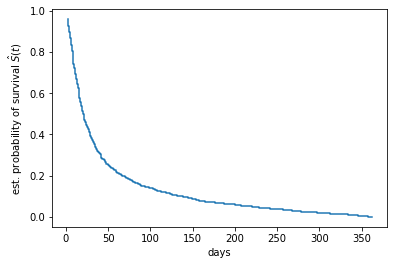

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["died"], data_y["survival_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("days")

## Estimador Nelson-Aalen

### Función de Riesgo Acumulativo

Text(0.5, 0, 'days')

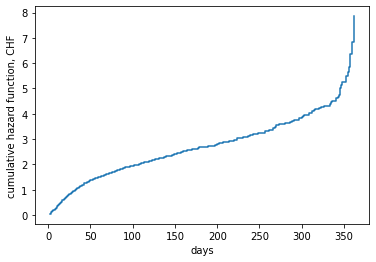

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import nelson_aalen_estimator

time, survival_chf = nelson_aalen_estimator(data_y["died"], data_y["survival_days"])
plt.step(time, survival_chf, where="post")
plt.ylabel("cumulative hazard function, CHF")
plt.xlabel("days")

### Función de Supervivencia

Text(0.5, 0, 'days')

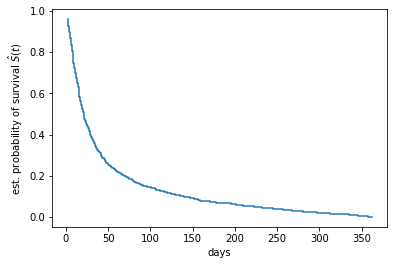

In [38]:
%matplotlib inline

survival_prob = np.exp(-survival_chf)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("days")